In [55]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.preprocessing import StandardScaler

import pycountry as pc
import pycountry_convert as pcct

# disable warnings
import warnings
warnings.filterwarnings('ignore')


In [79]:


def get_cont(country):
    country = country.strip()
    hard_coded = {
        'Turkey' : 'EU',
        'Korea Republic' : 'AS',
        'Korea DPR' : 'AS',
        'China PR' : 'AS',
        'Cape Verde' : 'AF',
        'Central African Rep.' : 'AF',
        'DR Congo' : 'AF',
        'Republic Of Ireland' : 'EU',
        'FYR Macedonia' : 'EU',
        'Guinea Bissau' : 'AF',
        'St Kitts Nevis' : 'NA',
        'Trinidad & Tobago' : 'NA',
        'São Tomé & Príncipe' : 'NA',
        'Antigua & Barbuda' : 'NA',
        'Chinese Taipei' : 'AS',
        'St Lucia' : 'NA',
        'Macau' : 'AS',
        'Bosnia Herzegovina' : 'EU',
        'Ivory Coast' : 'AF',
        'Republic of Ireland' : 'EU'
    }

    if country == 'republic of ireland':
        country = 'ireland'
    try:
        england = pc.countries.search_fuzzy(country)
        england = england[0].alpha_2
        continent = pcct.country_alpha2_to_continent_code(england)
    except:
        if country in hard_coded:
            continent = hard_coded[country]
            return continent
        else:
            print(country)
            continent = 'N/A'
            return continent
    return continent

In [80]:
def split_data(filepath='players_20.csv'):
    '''Loads and splits the data into features, target and protected columns
    Args:
        filepath: str, path to csv file
    Returns:
        df: pd.DataFrame, features
        target: pd.DataFrame, target columns
        protected: pd.DataFrame, protected columns
    '''
    cont_dict = {}
    df = pd.read_csv(filepath)
    for i in df.nationality.unique():
        cont_dict[i] = get_cont(i)

    # shuffle data
    df = df.sample(frac=1, random_state=0)

    # print number of na for each column
    df.fillna(0, inplace=True)

    # set index as sofifa_id
    df.set_index('sofifa_id', inplace=True)

    # drop unused columns
    drops = ['long_name', 'dob', 'player_url', 'release_clause_eur', 'overall', 'international_reputation']
    df.drop(drops, axis=1, inplace=True)

    # separate protected columns
    nationality = df['nationality']
    continents = df['nationality'].apply(lambda x: cont_dict[x])
    protected = ['nationality', 'club']
    protected_ = df[protected]
    df.drop(protected, axis=1, inplace=True)

    # filter positions to only primary
    df['player_positions'] = df['player_positions'].apply(lambda x: x.split(',')[0])

    # onehot encode player_positions
    df = pd.get_dummies(df, columns=['player_positions'])

    # drop all columns with object type
    df = df.select_dtypes(exclude=['object'])
    targets = ['value_eur', 'wage_eur']
    target = df[targets]

    # make targets boolean based on median
    print('Wage target value: ', target['wage_eur'].median())
    print('Wage top 10%: ', target['wage_eur'].quantile(0.9))
    print('Value target value: ', target['value_eur'].median())
    print('Value top 10%: ', target['value_eur'].quantile(0.9))
    target['wage_eur'] = target['wage_eur'] > target['wage_eur'].median()
    target['value_eur'] = target['value_eur'] > target['value_eur'].median()
    target = target.astype(int)

    df.drop(targets, axis=1, inplace=True)

    # One hot encoding of protected columns
    protected_ = pd.get_dummies(protected_)

    # drop na columns
    # df.dropna(inplace=True)
    # target = target.loc[df.index]
    # protected_ = protected_.loc[df.index]

    return df, target, protected_, nationality, continents
df, target, protected, nationality, continents = split_data()

SubdivisionHierarchy(code='GB-ENG', country_code='GB', name='England', parent_code=None, type='Country')
SubdivisionHierarchy(code='GB-SCT', country_code='GB', name='Scotland', parent_code=None, type='Country')
SubdivisionHierarchy(code='MX-MEX', country_code='MX', name='México', parent_code=None, type='State')


SubdivisionHierarchy(code='GN-ML', country_code='GN', name='Mali', parent='L', parent_code='GN-L', type='Prefecture')
SubdivisionHierarchy(code='GB-NIR', country_code='GB', name='Northern Ireland', parent_code=None, type='Province')
SubdivisionHierarchy(code='US-GA', country_code='US', name='Georgia', parent_code=None, type='State')
SubdivisionHierarchy(code='NL-CW', country_code='NL', name='Curaçao', parent_code=None, type='Country')
SubdivisionHierarchy(code='PA-8', country_code='PA', name='Panamá', parent_code=None, type='Province')
SubdivisionHierarchy(code='BE-WLX', country_code='BE', name='Luxembourg', parent='WAL', parent_code='BE-WAL', type='Province')
SubdivisionHierarchy(code='LU-LU', country_code='LU', name='Luxembourg', parent_code=None, type='Canton')
SubdivisionHierarchy(code='US-PR', country_code='US', name='Puerto Rico', parent_code=None, type='Outlying area')
SubdivisionHierarchy(code='BZ-BZ', country_code='BZ', name='Belize', parent_code=None, type='District')
Subdivi

In [81]:
## train test split

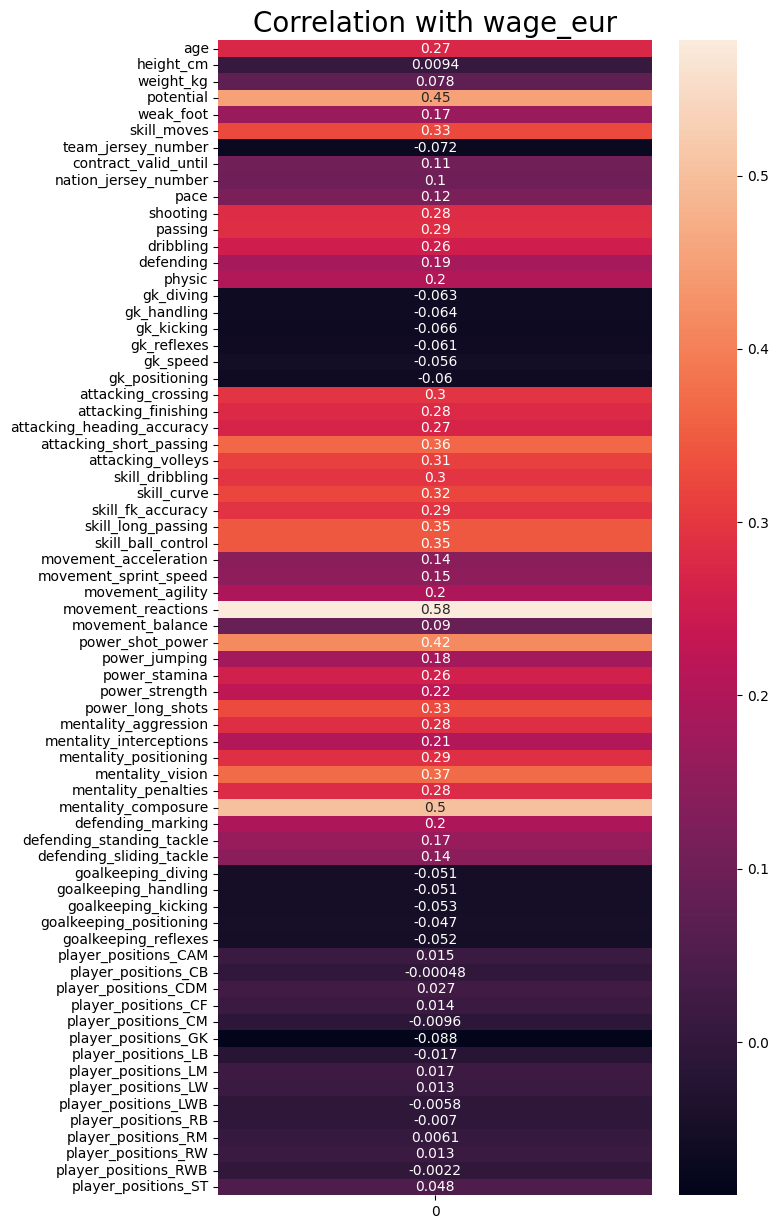

In [82]:
def comp_plot(df, comp_col='wage_eur'):
    # plot correlation between features and targets as heatmap
    correlation = df.corrwith(target[comp_col], method='pearson')
    fig, ax = plt.subplots(1, 1, figsize=(7, 15))
    ax = sns.heatmap(correlation.to_frame(), annot=True)
    plt.title(f'Correlation with {comp_col}', fontsize=20)
    return (fig, ax), correlation

(fig, ax), corr = comp_plot(df, 'wage_eur')

In [83]:
def preliminary_analysis(df, protected, target, clf):
    X_train, X_test, y_train, y_test = train_test_split(df, target, test_size=0.2, random_state=42)
    # scale features
    scaler = StandardScaler()
    X_train = pd.DataFrame(data = scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
    X_test = pd.DataFrame(data = scaler.transform(X_test), columns = X_test.columns, index=X_test.index)
    clf.fit(X_train, y_train)
    cv_scores = cross_val_score(clf, X_train, y_train, cv=5)
    print('Cross validation scores: ', cv_scores)
    print('Mean cross validation score: ', cv_scores.mean())
    return clf, X_train, X_test, y_train, y_test

clf = LogisticRegression(max_iter=1000)
clf, X_train, X_test, y_train, y_test = preliminary_analysis(df, protected, target['wage_eur'], clf)

Cross validation scores:  [0.83316239 0.82495726 0.83139535 0.82626539 0.83857729]
Mean cross validation score:  0.8308715376430834


In [84]:
# get cross validation score for each nationality
def get_cv_score(df, target, clf , nationality = nationality, cv=5):
    fold_length = len(df) // cv
    scores = {}
    for i in set(nationality):
        scores[i] = []
        start, end = 0, fold_length
        for j in range(cv):
            test = list(range(start, end))
            train = list(set(range(len(df))) - set(test))
            X_train, X_test = df.iloc[train], df.iloc[test]
            y_train, y_test = target.iloc[train], target.iloc[test]
            X_test = X_test.loc[nationality == i]
            y_test = y_test.loc[nationality == i]
            start = end
            end += fold_length
            try:
                clf.fit(X_train, y_train)
                score = clf.score(X_test, y_test)
                scores[i].append(score)
            except:
                scores[i].append(0)
    return scores

In [85]:
cvs = get_cv_score(X_train, y_train, clf, nationality=continents[X_train.index])
cvs = {k: np.mean(v) for k, v in cvs.items()}
# sort by key
cvs = dict(sorted(cvs.items()))

<Axes: >

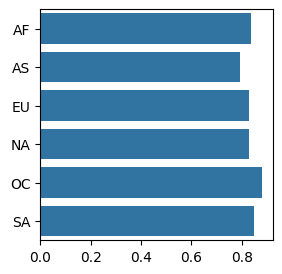

In [86]:
plt.figure(figsize=(3, 3))
sns.barplot(y=list(cvs.keys()), x=cvs.values())

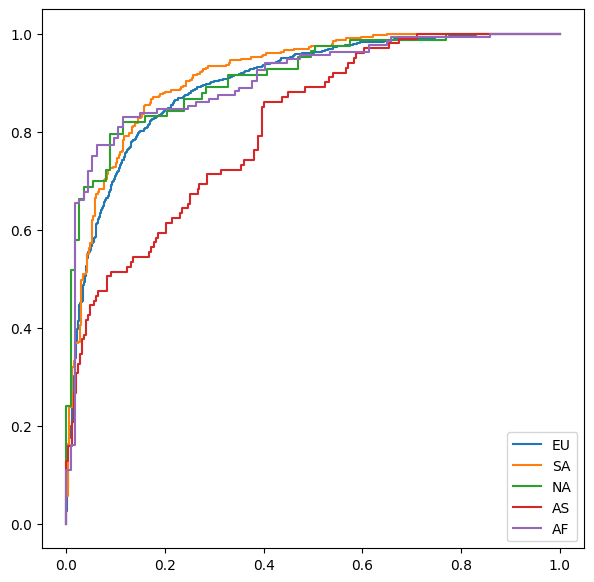

In [87]:
rocs = {}
for i in continents.unique():
    X_test_ = X_test.loc[continents == i]
    y_test_ = y_test.loc[continents == i]
    try:
        y_probs = clf.predict_proba(X_test_)
        y_probs = y_probs[:, 1]
        fpr, tpr, _ = roc_curve(y_test_, y_probs)
        rocs[i] = (fpr, tpr)
    except:
        pass

plt.figure(figsize=(7, 7))
for i in rocs:
    if len(rocs[i][0]) > 15:
        fpr, tpr = rocs[i]
        plt.plot(fpr, tpr, label=i)
plt.legend(loc='lower right')

AttributeError: 'LogisticRegression' object has no attribute 'feature_importances_'

In [95]:
continents.value_counts()

nationality
EU    11184
SA     3098
AS     1624
AF     1255
NA      883
OC      234
Name: count, dtype: int64

<Axes: xlabel='nationality', ylabel='count'>

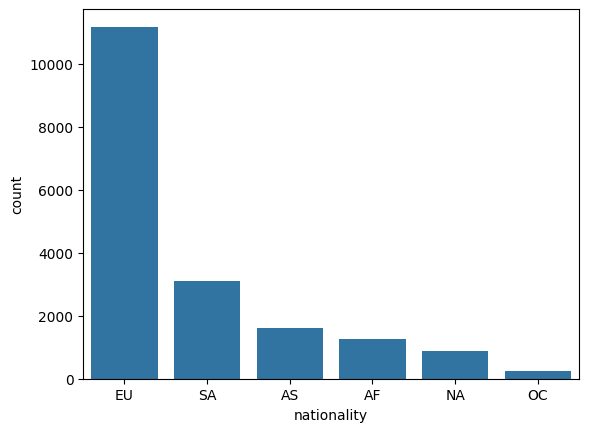

In [98]:
sns.barplot(continents.value_counts())

<Axes: >

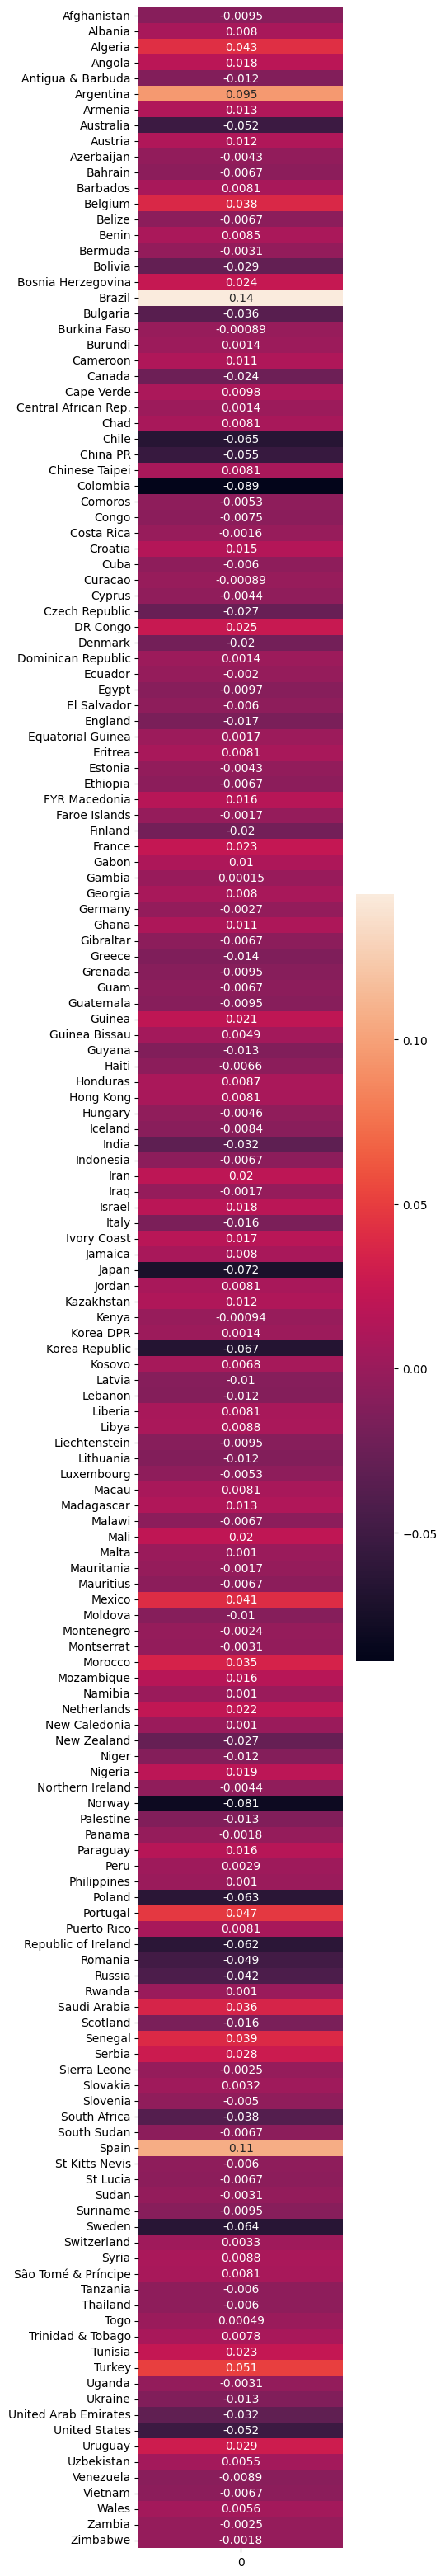

In [92]:
plt.figure(figsize=(4, 40))
countries = pd.get_dummies(nationality)
corr = countries.corrwith(target['wage_eur'], method='pearson')
sns.heatmap(corr.to_frame(), annot=True)

<Axes: >

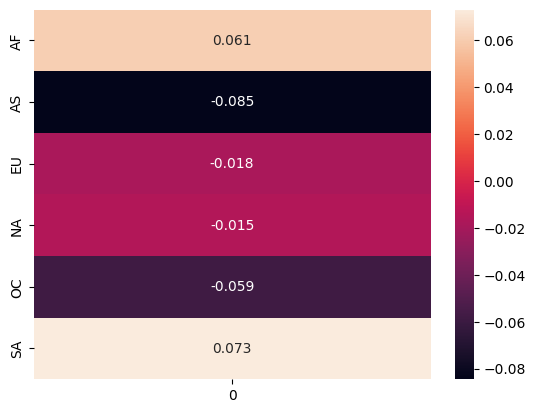

In [90]:
cont = pd.get_dummies(continents)
corr = cont.corrwith(target['wage_eur'], method='pearson')
sns.heatmap(corr.to_frame(), annot=True)